# TKT4108 Structural Dynamics 2

## Solution Exercise 10

**Main topics:** System identification

**References:** Github examples, lecture notes

### Problem 1


**a)**


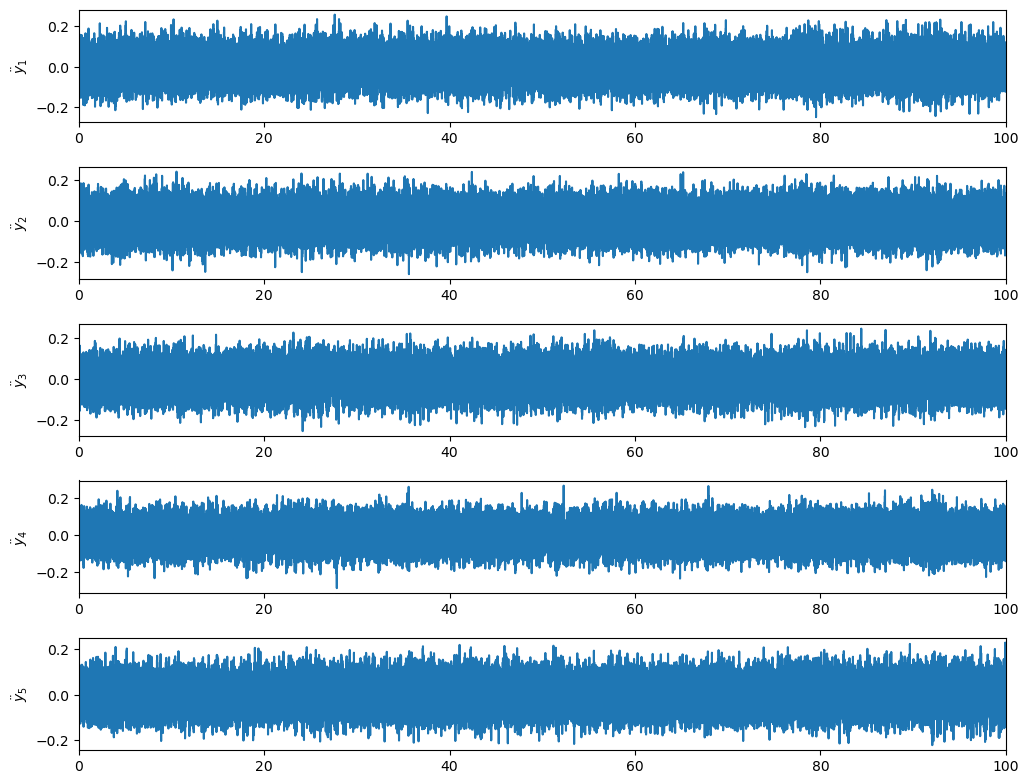

In [32]:
import numpy as np
from scipy import linalg as spla

import sys
sys.path.append('./../../modules')
from time_integration import * # Import all functions in the module time_integration

from matplotlib import pyplot as plt
from scipy import signal as spsi

M = np.eye(5) *1000
K = np.zeros((6,6))
EI = 2.1e11*3.34e-6
L = 3
ks = 2 *12*EI/L**3

for k in range(5):
    K[k+1,k+1] = K[k+1,k+1] + ks
    K[k,k] = K[k,k] + ks
    K[k+1,k] = K[k+1,k] -ks
    K[k,k+1] = K[k,k+1] -ks

K = K[1::,1::] # Introduce boundary conditions

lam, vec = spla.eig(K,M)

idx_sort = np.argsort(np.abs(lam))
lam = lam[idx_sort]
vec = vec[:,idx_sort]

fn = np.real(lam**0.5)/2/np.pi

M_modal = vec.T @ M @ vec

C_modal = 2*np.eye(5)*0.02*M_modal*np.diag(fn)*2*np.pi

C = vec @ C_modal @ vec.T

dt=0.001

t = np.arange(0,100,dt)

x=np.random.normal(0,50, size=(5,len(t))) # White noise loading

u0 = np.zeros((5,1))
udot0 = np.zeros((5,1))

_, _, y2dot = linear_newmark_krenk(M,C,K,x,u0,udot0,dt)

fix, axs = plt.subplots(5,1,figsize=(10,8))

plt.tight_layout()

for k in range(5):
    axs[k].plot(t,y2dot[k,:])
    axs[k].set_ylabel('$\ddot{y}_' + str(k+1) + '$')
    axs[k].set_xlim(0,100)


In [33]:

print('Natural frequencies are:')
print(fn*2*np.pi)

# Normalize modes such that largest value is 1
for k in range(vec.shape[0]):
    vec[:,k] = vec[:,k] / np.max(np.abs(vec[:,k]))

Natural frequencies are:
[ 7.10700791 20.74525622 32.70284724 42.01104807 47.91576364]


**b)**

The first step is to estimate the cross-spectral density of the response. We can use Welch's method since it provides a smooth estimate of the auto spectral and cross-spectral densities.

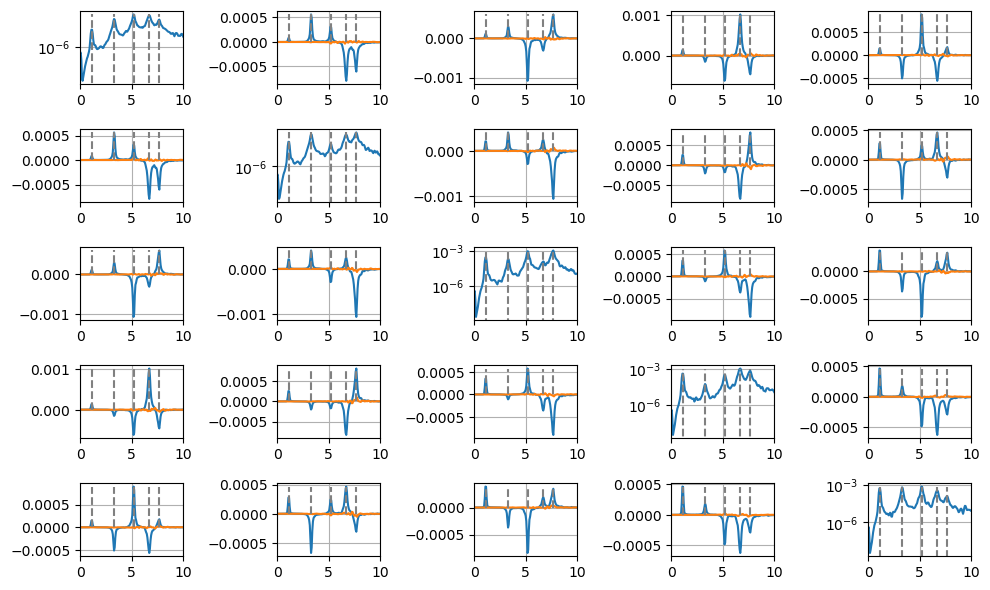

In [34]:
npoints_window = np.ceil(len(t)/10)
nfft_pow2 = 2**(np.ceil(np.log2(npoints_window))) # Next power of 2, to make the FFT more efficient

S_welch = np.zeros((y2dot.shape[0],y2dot.shape[0],int(nfft_pow2/2+1)),dtype=complex) #initialize the cross-spectral density matrix of the response
for k1 in range(y2dot.shape[0]):
    for k2 in range(y2dot.shape[0]):
        f_welch, S_tmp = spsi.csd(y2dot[k1,:],y2dot[k2,:], fs=1/dt, window='hann', nperseg=npoints_window, nfft=nfft_pow2 , detrend='constant')
        
        S_welch[k1,k2,:] = S_tmp # Spectrum in rad/s
        
fig, axs = plt.subplots(y2dot.shape[0],y2dot.shape[0], figsize=(10,6))

for k1 in range(y2dot.shape[0]):
    for k2 in range(y2dot.shape[0]):
        axs[k1,k2].plot(f_welch,np.real(S_welch[k1,k2,:]))
        
        if k1!=k2:
            axs[k1,k2].plot(f_welch,np.imag(S_welch[k1,k2,:]))
            
        axs[k1,k2].set_xlim(0,10)
        axs[k1,k2].grid(True)
        axs[k1,k2].vlines(fn,np.zeros(len(fn)),np.ones(len(fn))*np.max(np.real(S_welch[k1,k2,:])),colors='grey',linestyles='dashed')

        if k1==k2:
            axs[k1,k2].set_yscale('log')

plt.tight_layout()

From the auto and cross-spectral densities, we can quickly identify four tall peaks and one smaller one. The vertical lines corresponding to the true natural frequencies are helpful. Knowing the exact natural frequencies beforehand is impossible for actual structures, so one must rely on the clear peaks in an actual situation. 

It is often the case that not all the structure's natural frequencies show up in the auto- and cross-spectral densities. This occurs if some vibration modes are not excited by the loads acting on the structure. Another possible reason is if some of the natural frequencies are closely spaced such that the two peaks appear as one broader peak in the auto- and cross-spectral densities. Therefore, it is crucial to test different window lengths and assess the optimal size of the window for the particular case considered. Using too many windows may result in over-smoothing, and some of the peaks disappear.

It is common to take the sum of the auto-spectral densities and pick the peaks. If the auto-spectral densities have different magnitudes, it is possible to use a weighted sum to make it easier to identify the peaks. Here the auto-spectral densities are of similar magnitude, and we can thus disregard weighting.


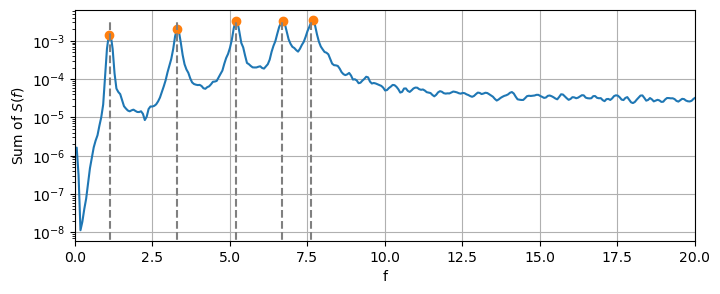

In [35]:
S = S_welch[0,0,:] +  S_welch[1,1,:] +  S_welch[2,2,:] +  S_welch[3,3,:] +  S_welch[4,4,:]

peaks_index,_ = spsi.find_peaks((np.abs(S)), distance=10,height=1e-4,prominence=0.0001)

plt.figure(figsize=(8,3))
plt.plot(f_welch,np.real(S))
plt.plot(f_welch[peaks_index],np.real(S[peaks_index]),'o')
plt.vlines(fn,np.zeros(len(fn)),np.ones(len(fn))*np.max(np.real(S)),colors='grey',linestyles='--')

plt.yscale('log')
plt.ylabel('Sum of $S(f)$')
plt.xlabel('f')
plt.xlim(0,20)
plt.grid()

As can be seen, the identified peaks correspond very well to the true natural frequencies of the system (the grey dashed lines). The next step is to obtain the vibration modes from the auto- and cross-spectral densities. It is assumed that only one mode contributes to the response at the peaks in the spectral densities. This implies that the following expression can approximate the auto-spectral density in the degree of freedom k.

$$S_{yk}(\omega_n) = v_{nk} S_{\eta}(\omega_n) v_{rk} = v_{nk}^2 S_{\eta}(\omega_n) $$

The modes are then found by first setting a reference value for one of the degrees of freedom, and the rest are found by the ratio of the value of the auto-spectral densities at the considered natural frequency. The sign of the mode shape value is taken from the real part of the cross-spectral density. A positive real part means that the points move in the same direction, while a negative sign implies that the correlation is negative and that the points move in opposite directions. The following python script obtains the vibration modes. The results are compared to the actual modes of the structure in the figure below.

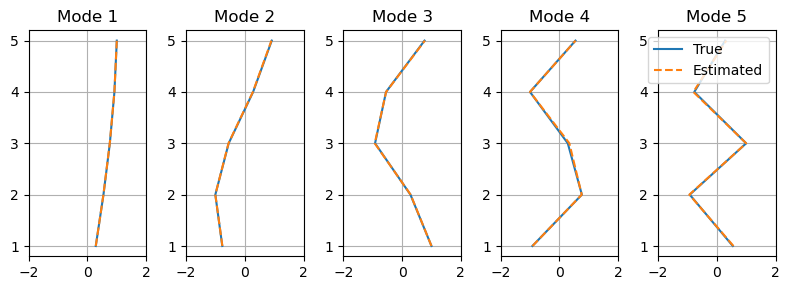

In [36]:
# Estimate the mode shapes from the cross-spectral density matrix of the response
phi_est = np.zeros((S_welch.shape[0],S_welch.shape[0]))
for k in range(peaks_index.shape[0]):
    phi_est[0,k] = 1.0
    for n in range(1,S_welch.shape[0]):
        phi_est[n,k] = np.real(S_welch[n,n,peaks_index[k]]/S_welch[0,0,peaks_index[k]])**0.5*np.sign(np.real(S_welch[0,n,peaks_index[k]]))   
        
# Normalize modes such that largest value is 1
for k in range(phi_est.shape[0]):
    phi_est[:,k] = phi_est[:,k] / np.max(np.abs(phi_est[:,k]))

# Change the sign of the modes to compare with target values
phi_est[:,1] = phi_est[:,1]*-1
phi_est[:,3] = phi_est[:,3]*-1

# Plot modes and compare to target values
fig, axs = plt.subplots(1,5,figsize=(8,3))

for k in range(phi_est.shape[1]):
    axs[k].plot(vec[:,k],np.arange(1,6),label='True')
    axs[k].plot(phi_est[:,k],np.arange(1,6),linestyle='--',label='Estimated')
    axs[k].set_title('Mode ' + str(k+1))
    axs[k].grid(True)
    axs[k].set_xlim(-2,2)

axs[k].legend()
plt.tight_layout()

The vibration modes estimated from the time series correspond to the actual vibration modes excellently. In a real situation where measurement noise is present and the excitation of the structure is weaker, we need to expect more significant discrepancies from the actual modes. The results illustrate, however, that we have implemented the basic frequency domain method correctly.

**c)** 

The starting point of frequency domain decomposition is to estimate the cross-spectral density matrix of the response. The cross-spectral density matrix is then factorized using the singular value decomposition.

$$\mathbf{S_y}(\omega)=\mathbf{U}(\omega) \mathbf{\Sigma}(\omega) \mathbf{V}(\omega)^\text{H}$$

Here $\mathbf{U}(\omega)$ and $\mathbf{V}(\omega)^\text{H}$ represents the left and right singular vectors while the diagonal matrix $\mathbf{\Sigma}(\omega)$ contains the singular values. Similar to the basic frequency domain method, we now assume that only one mode contributes to the response at the natural frequencies of the system. Sometimes, two or more modes can have the same natural frequency. In such cases, two or more singular values are significant, and we can identify all modes by considering all significant singular values and corresponding vectors. In most cases, the structure has natural frequencies that are different. This implies that only the largest singular value and the corresponding left and right singular vectors are important. The relation between the cross-spectral density matrix in modal coordinates and the one in physical dofs can be written as shown below

$$ \mathbf{S}_y(\omega)= \mathbf{\Phi}\mathbf{S}_{\eta}(\omega) \mathbf{\Phi}^\text{H}$$

Here $\mathbf{\Phi}$ is the vibration modes of the structure, and $\mathbf{S}_{\eta}(\omega)$ is the cross-spectral density matrix of the response in normal (modal) coordinates. Comparing the two expressions, we see that the singular vectors corresponding to the largest singular values can be used to approximate the modes. The code for the FDD is shown below. Keep in mind that we can use the estimate of the response-cross spectral density from problem a

Text(0.5, 1.0, 'Singular values')

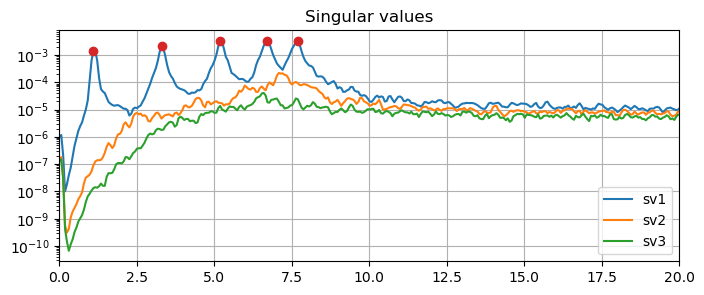

In [37]:
singular_values = np.zeros((3,len(f_welch)))
first_left_singular_vectors = np.zeros((5,len(f_welch)),dtype=complex)

for k in range(len(f_welch)):
    
    us, sigma, vs = spla.svd(S_welch[:,:,k])
    
    singular_values[:,k] = sigma[0:3]
    first_left_singular_vectors[:,k] = us[:,0]
    
peaks_index,_ = spsi.find_peaks(singular_values[0,:], distance=15, height=5e-4) 
    
plt.figure(figsize=(8,3))
plt.plot(f_welch,singular_values[0,:],label='sv1')
plt.plot(f_welch,singular_values[1,:],label='sv2')
plt.plot(f_welch,singular_values[2,:],label='sv3')
plt.plot(f_welch[peaks_index],singular_values[0,peaks_index],'o')
plt.yscale('log')
plt.xlim(0,20)
plt.grid()
plt.legend()
plt.title('Singular values')

The plots of the singular values illustrate that we can model most of the cross-spectral density matrix of the response by the first singular values and the corresponding vectors. The first singular value, in particular, dominates the contribution to the auto-and cross-spectral densities at the peaks. We can now plot the modes by considering the singular vectors corresponding to the largest singular value at the peaks in the singular value plot above.

Note that picking the peaks in the singular value plot can be tricky. It can to some extent be automated by tuning the 
*distance* and *height* arguments in the *find_peaks* function. It is also possible to manually pick the frequencies.

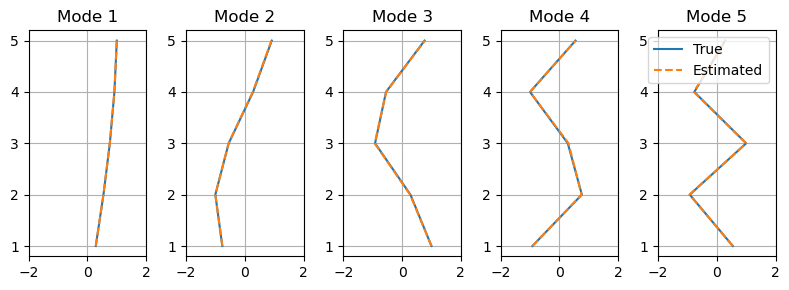

In [38]:
# Pick the modes from the singular vectors
modes_fdd = np.zeros((5,5),dtype=complex)
for k in range(peaks_index.shape[0]):
    modes_fdd[:,k] = first_left_singular_vectors[:,peaks_index[k]]
    modes_fdd[:,k] = modes_fdd[:,k]/np.max(np.abs(np.real(modes_fdd[:,k])))

# Change sign to make comparison easier
modes_fdd[:,0] = modes_fdd[:,0]*-1
modes_fdd[:,2] = modes_fdd[:,2]*-1
modes_fdd[:,4] = modes_fdd[:,4]*-1

# Plot modes and compare to target values
fig, axs = plt.subplots(1,5,figsize=(8,3))

for k in range(modes_fdd.shape[1]):

    axs[k].plot(vec[:,k],np.arange(1,6),label='True')
    axs[k].plot(np.real(modes_fdd[:,k]),np.arange(1,6),linestyle='--',label='Estimated')
    
    axs[k].set_title('Mode ' + str(k+1))
    axs[k].grid(True)
    axs[k].set_xlim(-2,2)

axs[k].legend()
plt.tight_layout()

The results from the FDD corresponds very well to the targets.

### Problem 2


We import the data

In [39]:
import numpy as np
from matplotlib import pyplot as plt
import scipy

acc_labels=np.loadtxt('hangarbrua_data_processed.txt',delimiter=',',skiprows=0, max_rows=1, dtype=str, usecols=range(1,61)) # Import labels

print('Acceleration labels: ')
print(acc_labels)

t=np.loadtxt('hangarbrua_data_processed.txt',delimiter=',',skiprows=1, usecols=[0]).T # Import time vector

acc=np.loadtxt('hangarbrua_data_processed.txt',delimiter=',',skiprows=1, usecols=range(1,61)).T # Import acceleration data

accm=np.mean(acc,axis=1)
acc=acc-np.atleast_2d(accm).T # Subtract the mean value

print('Length of time series in seconds:')
print(t[-1])

dt=t[2]-t[1]
fs=1/dt

print('Sample rate in Hz:')
print(fs)


Acceleration labels: 
['node1_x' 'node1_y' 'node1_z' 'node2_x' 'node2_y' 'node2_z' 'node3_x'
 'node3_y' 'node3_z' 'node4_x' 'node4_y' 'node4_z' 'node5_x' 'node5_y'
 'node5_z' 'node6_x' 'node6_y' 'node6_z' 'node7_x' 'node7_y' 'node7_z'
 'node8_x' 'node8_y' 'node8_z' 'node9_x' 'node9_y' 'node9_z' 'node10_x'
 'node10_y' 'node10_z' 'node11_x' 'node11_y' 'node11_z' 'node12_x'
 'node12_y' 'node12_z' 'node13_x' 'node13_y' 'node13_z' 'node14_x'
 'node14_y' 'node14_z' 'node15_x' 'node15_y' 'node15_z' 'node16_x'
 'node16_y' 'node16_z' 'node17_x' 'node17_y' 'node17_z' 'node18_x'
 'node18_y' 'node18_z' 'node19_x' 'node19_y' 'node19_z' 'node20_x'
 'node20_y' 'node20_z']
Length of time series in seconds:
693.125
Sample rate in Hz:
64.00098305509972


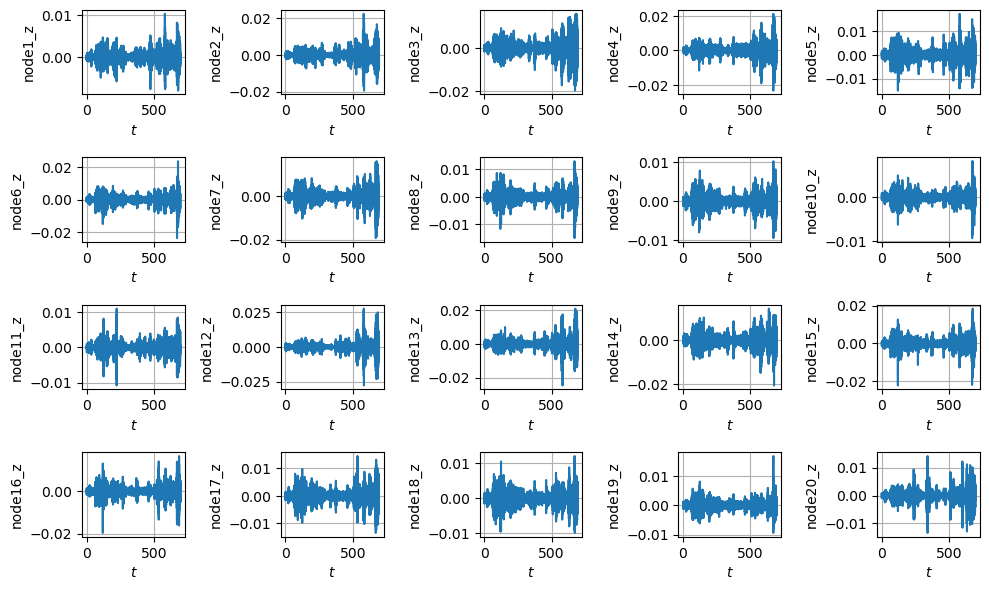

In [40]:
# Coordinate of sensors in [mm]
sensor_x=np.array([0,5785,11455,17298,20455,23835,27604,32004,37384,44584,0,5788,11458,17301,20445,23835,27604,32004,37384,44584,])
sensor_y=np.array([-4261,-4261,-4261,-4261,-4261,-4261,-4261,-4261,-4261,-4261,4261,4261,4261,4261,4261,4261,4261,4261,4261,4261])

index_x=range(0,60,3) # Index of all x-data (axial)
index_y=range(1,60,3) # Index of all y-data (transversal)
index_z=range(2,60,3) # Index of all z-data (vertical)

acc_z=acc[index_z,:] # Only vertical data
acc_labels_z=acc_labels[index_z]

# Plot all 20 vertical accelerations
idx=-1
fig, axs = plt.subplots(4,5,figsize=(10,6))    
for k1 in range(4):
    for k2 in range(5):
        ax = axs[k1,k2]

        idx=idx+1
        ax.plot(t,acc_z[idx])
        
        ax.set_ylabel(acc_labels_z[idx])
        ax.set_xlabel('$t$')
        ax.grid(True)
        
plt.tight_layout()



#### Vertical modes 
Next, we estimate the cross-spectral density matrix using Welch's method (vertical data only).



In [41]:
npoints_window = np.ceil(len(t)/ 10)
nfft_pow2 = 2**(np.ceil(np.log2(npoints_window))) # Next power of 2, to make the FFT more efficient

S_welch = np.zeros((acc_z.shape[0],acc_z.shape[0],int(nfft_pow2/2+1)),dtype=complex) #initialize the cross-spectral density matrix of the response
for k1 in range(acc_z.shape[0]):
    for k2 in range(acc_z.shape[0]):
        f_welch, S_tmp = scipy.signal.csd(acc_z[k1,:],acc_z[k2,:], fs=fs, window='hann', nperseg=npoints_window, nfft=nfft_pow2 , detrend='constant')
        
        S_welch[k1,k2,:] = S_tmp # Spectrum in rad/s


Now we look at the singular value spectrum. 

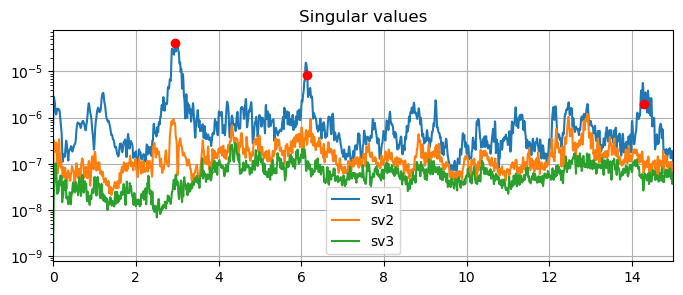

In [42]:
singular_values = np.zeros((3,len(f_welch)))
first_left_singular_vectors = np.zeros((20,len(f_welch)),dtype=complex)

for k in range(len(f_welch)):
    
    us, sigma, vs = scipy.linalg.svd(S_welch[:,:,k])
    
    singular_values[:,k] = sigma[0:3]
    first_left_singular_vectors[:,k] = us[:,0]
    
plt.figure(figsize=(8,3))
plt.plot(f_welch,singular_values[0,:],label='sv1')
plt.plot(f_welch,singular_values[1,:],label='sv2')
plt.plot(f_welch,singular_values[2,:],label='sv3')
plt.yscale('log')
plt.xlim(0,15)
plt.grid()
plt.legend()
plt.title('Singular values')

f_peak=[2.95 , 6.15 , 14.3]

for k in range(len(f_peak)):

    idx=np.argmin(np.abs(f_welch-f_peak[k]))
    plt.plot(f_welch[idx],singular_values[0,idx],'o',color='r')


Here, it is more difficult to use an automated code to pick out the peaks, since some of the peaks are either small or overlapping. We have selected the following three:

- **2.95 Hz**: First peak, likely dominant mode excited by pedestrians
- **6.15 Hz**: Second peak, likely a vibration mode
- **14.3 Hz**: Another peak worthy of investigation


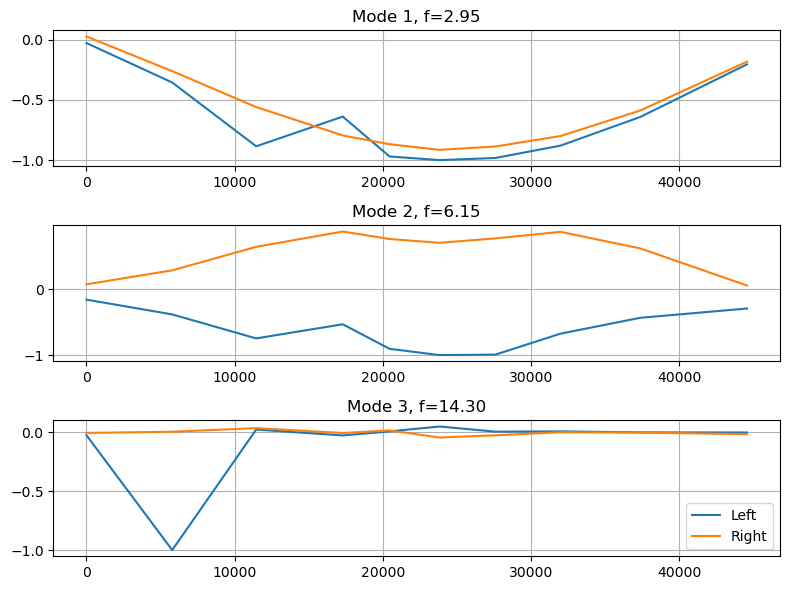

In [43]:

# Plot modes and compare to target values
fig, axs = plt.subplots(3,1,figsize=(8,6))

for k in range(len(f_peak)):

    idx=np.argmin(np.abs(f_welch-f_peak[k]))

    mode_plot=np.real(first_left_singular_vectors[:,idx]);

    mode_plot=mode_plot/np.max(np.abs(mode_plot))

    idx_left=[0,1,2,3,4,5,6,7,8,9]
    idx_right=[10,11,12,13,14,15,16,17,18,19]

    axs[k].plot(sensor_x[idx_left],mode_plot[idx_left],linestyle='-',label='Left')
    axs[k].plot(sensor_x[idx_right],mode_plot[idx_right],linestyle='-',label='Right')
    
    axs[k].set_title('Mode ' + str(k+1) + ', f=' '{:.2f}'.format(f_peak[k]) )
    axs[k].grid()
    
   # axs[k].set_xlim(-2,2)

axs[k].legend()
plt.tight_layout()

From the mode shapes we conclude:

- **2.95 Hz**: Global vertical bending mode
- **6.15 Hz**: Global torsional mode
- **14.3 Hz**: This mode shape is only active for a single sensor. It therefore might be vibrations of the cable that the sensor was attached to. We consider this a local mode.

#### Transversal modes 
Next, we consider transversal modes in the same fashion.


In [46]:
acc_y=acc[index_y,:] # Only horizontal data

npoints_window = np.ceil(len(t)/ 10)
nfft_pow2 = 2**(np.ceil(np.log2(npoints_window))) # Next power of 2, to make the FFT more efficient

S_welch = np.zeros((acc_y.shape[0],acc_y.shape[0],int(nfft_pow2/2+1)),dtype=complex) #initialize the cross-spectral density matrix of the response
for k1 in range(acc_y.shape[0]):
    for k2 in range(acc_y.shape[0]):
        f_welch, S_tmp = scipy.signal.csd(acc_y[k1,:],acc_y[k2,:], fs=fs, window='hann', nperseg=npoints_window, nfft=nfft_pow2 , detrend='constant')
        
        S_welch[k1,k2,:] = S_tmp # Spectrum in rad/s

Text(0.5, 1.0, 'Singular values')

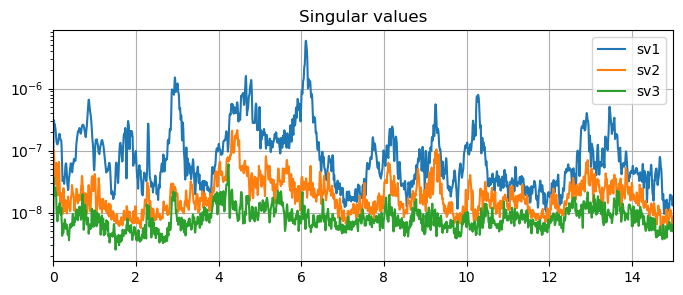

In [47]:
singular_values = np.zeros((3,len(f_welch)))
first_left_singular_vectors = np.zeros((20,len(f_welch)),dtype=complex)

for k in range(len(f_welch)):
    
    us, sigma, vs = scipy.linalg.svd(S_welch[:,:,k])
    
    singular_values[:,k] = sigma[0:3]
    first_left_singular_vectors[:,k] = us[:,0]
    
plt.figure(figsize=(8,3))
plt.plot(f_welch,singular_values[0,:],label='sv1')
plt.plot(f_welch,singular_values[1,:],label='sv2')
plt.plot(f_welch,singular_values[2,:],label='sv3')
plt.yscale('log')
plt.xlim(0,15)
plt.grid()
plt.legend()
plt.title('Singular values')


It is hard to find modes that are pure transversal motion. Here, the largest peaks (2.95 Hz, 6.15 Hz) coincide with the ones from the vertical analysis. 
There are a few possible reasons why:

- The transversal modes are not properly excited by pedestrians
- The transversal modes have frequencies well above 15 Hz due to the stiff deck
- The transversal modes mainly include motions of the arch, not the stiffer deck where the sensors are located
- The torsional mode also includes some minor transversal components
- The accelerometers are not perfectly installed (rotated), so the *y*-component will pick up vertical motion as well
